# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

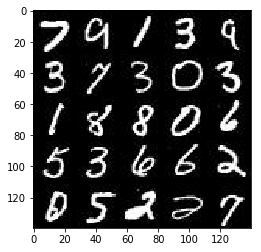

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

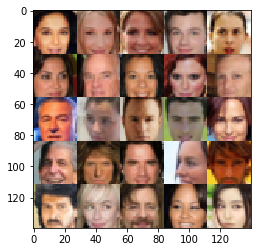

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate=tf.placeholder(tf.float32,None,name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha=0.02
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        h1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', 
                              kernel_initializer = tf.contrib.layers.xavier_initializer(uniform=True, seed=None, dtype=tf.float32))
        relu1 = tf.maximum(alpha * h1, h1)
        
        h2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=True, seed=None, dtype=tf.float32))
        bn2 = tf.layers.batch_normalization(h2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        h3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=True, seed=None, dtype=tf.float32))
        bn3 = tf.layers.batch_normalization(h3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)

        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha=0.2
    
    with tf.variable_scope('generator', reuse=not is_train):

        h1 = tf.layers.dense(z, 7*7*512)
        # Reshape
        h1 = tf.reshape(h1, (-1, 7, 7, 512))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(alpha * h1, h1)
        
        h2 = tf.layers.conv2d_transpose(h1, 256, 5, strides=2, padding='same')
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(alpha * h2, h2)
        
        h3 = tf.layers.conv2d_transpose(h2, 128, 5, strides=2, padding='same')
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(alpha * h3, h3)
        
        # Output
        logits = tf.layers.conv2d_transpose(h3, out_channel_dim, 5, strides=1, padding='same')
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """  
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    samples, losses = [], []
    steps = 0
    print_every = 10
    show_every = 100
    
    out_channel_dim = 3
    if (data_image_mode == "L"):
        out_channel_dim = 1
        
    inputs_real, inputs_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(inputs_real, inputs_z, out_channel_dim)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_train_opt, feed_dict={inputs_real:batch_images, inputs_z:batch_z, lr:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={inputs_real:batch_images, inputs_z:batch_z, lr:learning_rate})
                
                _ = sess.run(g_train_opt, feed_dict={inputs_real:batch_images, inputs_z:batch_z, lr:learning_rate})
              
                #print
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({inputs_z:batch_z, inputs_real:batch_images})
                    train_loss_g = g_loss.eval({inputs_z:batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    losses.append((train_loss_d, train_loss_g))    
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 9, inputs_z, data_shape[3], data_image_mode)                  
                                                       
        show_generator_output(sess, 9, inputs_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.3176... Generator Loss: 0.8671
Epoch 1/2... Discriminator Loss: 2.7261... Generator Loss: 0.1072
Epoch 1/2... Discriminator Loss: 2.4067... Generator Loss: 0.2551
Epoch 1/2... Discriminator Loss: 2.1807... Generator Loss: 0.2708
Epoch 1/2... Discriminator Loss: 1.9292... Generator Loss: 0.3159
Epoch 1/2... Discriminator Loss: 2.1175... Generator Loss: 0.1968
Epoch 1/2... Discriminator Loss: 1.6388... Generator Loss: 0.5111
Epoch 1/2... Discriminator Loss: 1.7082... Generator Loss: 0.6205
Epoch 1/2... Discriminator Loss: 1.7926... Generator Loss: 0.2688
Epoch 1/2... Discriminator Loss: 1.6747... Generator Loss: 0.5111


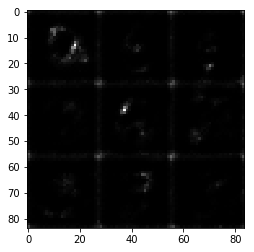

Epoch 1/2... Discriminator Loss: 1.5231... Generator Loss: 0.4546
Epoch 1/2... Discriminator Loss: 1.8440... Generator Loss: 0.2350
Epoch 1/2... Discriminator Loss: 2.0654... Generator Loss: 0.1695
Epoch 1/2... Discriminator Loss: 1.6742... Generator Loss: 0.2997
Epoch 1/2... Discriminator Loss: 1.7221... Generator Loss: 0.2947
Epoch 1/2... Discriminator Loss: 1.6948... Generator Loss: 0.8661
Epoch 1/2... Discriminator Loss: 1.7553... Generator Loss: 0.3169
Epoch 1/2... Discriminator Loss: 1.9462... Generator Loss: 0.2474
Epoch 1/2... Discriminator Loss: 1.6898... Generator Loss: 0.4504
Epoch 1/2... Discriminator Loss: 1.6393... Generator Loss: 0.4148


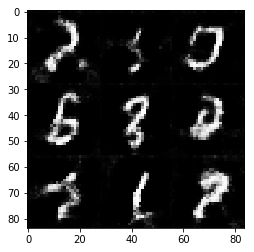

Epoch 1/2... Discriminator Loss: 1.6516... Generator Loss: 0.3105
Epoch 1/2... Discriminator Loss: 1.6872... Generator Loss: 0.3428
Epoch 1/2... Discriminator Loss: 1.8405... Generator Loss: 0.2659
Epoch 1/2... Discriminator Loss: 1.5967... Generator Loss: 0.4121
Epoch 1/2... Discriminator Loss: 1.6296... Generator Loss: 0.4758
Epoch 1/2... Discriminator Loss: 1.6624... Generator Loss: 0.7767
Epoch 1/2... Discriminator Loss: 1.5613... Generator Loss: 0.6921
Epoch 1/2... Discriminator Loss: 1.6031... Generator Loss: 0.3937
Epoch 1/2... Discriminator Loss: 1.4602... Generator Loss: 0.5854
Epoch 1/2... Discriminator Loss: 1.5481... Generator Loss: 0.4760


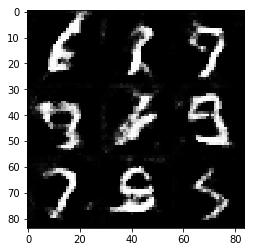

Epoch 1/2... Discriminator Loss: 1.4959... Generator Loss: 0.4927
Epoch 1/2... Discriminator Loss: 1.6618... Generator Loss: 0.3342
Epoch 1/2... Discriminator Loss: 1.6264... Generator Loss: 0.4269
Epoch 1/2... Discriminator Loss: 1.6429... Generator Loss: 0.3755
Epoch 1/2... Discriminator Loss: 1.5714... Generator Loss: 0.3926
Epoch 1/2... Discriminator Loss: 1.4247... Generator Loss: 0.6346
Epoch 1/2... Discriminator Loss: 1.4667... Generator Loss: 0.5296
Epoch 1/2... Discriminator Loss: 1.4646... Generator Loss: 0.5830
Epoch 1/2... Discriminator Loss: 1.7934... Generator Loss: 0.2812
Epoch 1/2... Discriminator Loss: 2.0015... Generator Loss: 0.1880


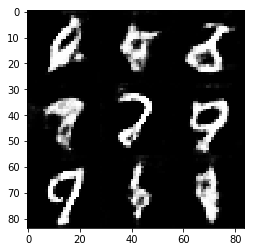

Epoch 1/2... Discriminator Loss: 1.5195... Generator Loss: 0.7508
Epoch 1/2... Discriminator Loss: 1.6003... Generator Loss: 0.3763
Epoch 1/2... Discriminator Loss: 1.5548... Generator Loss: 0.4329
Epoch 1/2... Discriminator Loss: 1.4717... Generator Loss: 0.7494
Epoch 1/2... Discriminator Loss: 1.4477... Generator Loss: 0.8270
Epoch 1/2... Discriminator Loss: 1.4455... Generator Loss: 0.5650
Epoch 1/2... Discriminator Loss: 1.5148... Generator Loss: 0.5102
Epoch 1/2... Discriminator Loss: 1.5289... Generator Loss: 0.4470
Epoch 1/2... Discriminator Loss: 1.7523... Generator Loss: 1.1969
Epoch 1/2... Discriminator Loss: 1.3696... Generator Loss: 0.7756


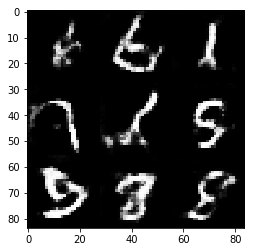

Epoch 1/2... Discriminator Loss: 1.6226... Generator Loss: 0.3357
Epoch 1/2... Discriminator Loss: 1.5091... Generator Loss: 0.4016
Epoch 1/2... Discriminator Loss: 1.7815... Generator Loss: 0.2378
Epoch 1/2... Discriminator Loss: 1.6935... Generator Loss: 0.3116
Epoch 1/2... Discriminator Loss: 1.6070... Generator Loss: 0.3525
Epoch 1/2... Discriminator Loss: 1.3366... Generator Loss: 0.6086
Epoch 1/2... Discriminator Loss: 1.5054... Generator Loss: 0.5861
Epoch 1/2... Discriminator Loss: 1.8142... Generator Loss: 0.2498
Epoch 1/2... Discriminator Loss: 1.5550... Generator Loss: 0.4118
Epoch 1/2... Discriminator Loss: 1.4936... Generator Loss: 0.9223


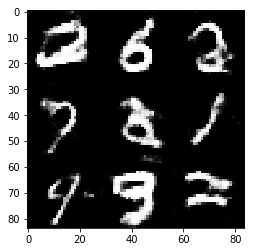

Epoch 1/2... Discriminator Loss: 1.5177... Generator Loss: 0.3976
Epoch 1/2... Discriminator Loss: 1.3703... Generator Loss: 0.5398
Epoch 1/2... Discriminator Loss: 1.4182... Generator Loss: 0.5674
Epoch 1/2... Discriminator Loss: 1.7481... Generator Loss: 0.2668
Epoch 1/2... Discriminator Loss: 1.3716... Generator Loss: 0.4547
Epoch 1/2... Discriminator Loss: 1.6345... Generator Loss: 0.2889
Epoch 1/2... Discriminator Loss: 1.3858... Generator Loss: 0.7828
Epoch 1/2... Discriminator Loss: 1.3380... Generator Loss: 0.7426
Epoch 1/2... Discriminator Loss: 1.5281... Generator Loss: 0.8849
Epoch 1/2... Discriminator Loss: 1.4319... Generator Loss: 0.5998


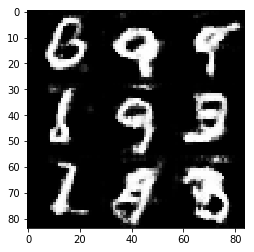

Epoch 1/2... Discriminator Loss: 1.5030... Generator Loss: 0.3684
Epoch 1/2... Discriminator Loss: 1.6223... Generator Loss: 0.3067
Epoch 1/2... Discriminator Loss: 2.0204... Generator Loss: 0.1900
Epoch 1/2... Discriminator Loss: 1.5400... Generator Loss: 0.3523
Epoch 1/2... Discriminator Loss: 1.2786... Generator Loss: 0.8930
Epoch 1/2... Discriminator Loss: 1.2894... Generator Loss: 0.7544
Epoch 1/2... Discriminator Loss: 1.5299... Generator Loss: 0.3818
Epoch 1/2... Discriminator Loss: 1.2336... Generator Loss: 0.6062
Epoch 1/2... Discriminator Loss: 1.5435... Generator Loss: 0.3316
Epoch 1/2... Discriminator Loss: 1.6535... Generator Loss: 0.3772


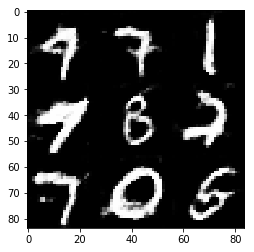

Epoch 1/2... Discriminator Loss: 1.1893... Generator Loss: 0.8074
Epoch 1/2... Discriminator Loss: 1.2736... Generator Loss: 0.5060
Epoch 1/2... Discriminator Loss: 1.7974... Generator Loss: 0.2632
Epoch 1/2... Discriminator Loss: 1.5115... Generator Loss: 0.3824
Epoch 1/2... Discriminator Loss: 1.3852... Generator Loss: 0.6954
Epoch 1/2... Discriminator Loss: 1.4344... Generator Loss: 0.3792
Epoch 1/2... Discriminator Loss: 1.6380... Generator Loss: 0.2860
Epoch 1/2... Discriminator Loss: 1.2970... Generator Loss: 0.8234
Epoch 1/2... Discriminator Loss: 1.5888... Generator Loss: 0.3350
Epoch 1/2... Discriminator Loss: 1.2581... Generator Loss: 0.7192


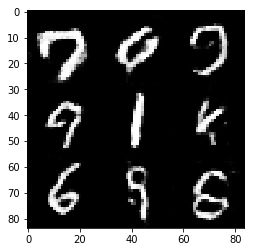

Epoch 1/2... Discriminator Loss: 1.2235... Generator Loss: 0.5814
Epoch 1/2... Discriminator Loss: 1.2922... Generator Loss: 0.5415
Epoch 1/2... Discriminator Loss: 1.5404... Generator Loss: 0.3665
Epoch 2/2... Discriminator Loss: 1.2657... Generator Loss: 0.6531
Epoch 2/2... Discriminator Loss: 1.6943... Generator Loss: 0.2814
Epoch 2/2... Discriminator Loss: 1.1462... Generator Loss: 1.0038
Epoch 2/2... Discriminator Loss: 1.0995... Generator Loss: 0.6652
Epoch 2/2... Discriminator Loss: 1.1538... Generator Loss: 0.5318
Epoch 2/2... Discriminator Loss: 1.1580... Generator Loss: 0.9464
Epoch 2/2... Discriminator Loss: 2.1671... Generator Loss: 0.1595


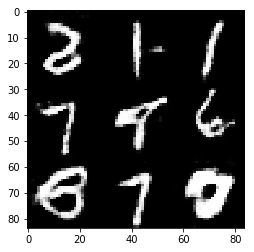

Epoch 2/2... Discriminator Loss: 1.3882... Generator Loss: 0.4340
Epoch 2/2... Discriminator Loss: 1.0708... Generator Loss: 1.0787
Epoch 2/2... Discriminator Loss: 1.3505... Generator Loss: 0.5428
Epoch 2/2... Discriminator Loss: 1.6646... Generator Loss: 0.3037
Epoch 2/2... Discriminator Loss: 1.4503... Generator Loss: 2.3711
Epoch 2/2... Discriminator Loss: 1.5958... Generator Loss: 0.3650
Epoch 2/2... Discriminator Loss: 1.3877... Generator Loss: 0.5570
Epoch 2/2... Discriminator Loss: 1.3279... Generator Loss: 0.5176
Epoch 2/2... Discriminator Loss: 1.3657... Generator Loss: 0.4855
Epoch 2/2... Discriminator Loss: 1.0061... Generator Loss: 1.1705


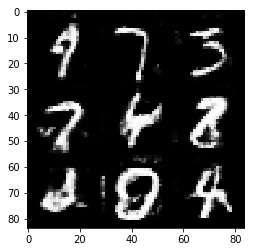

Epoch 2/2... Discriminator Loss: 1.1072... Generator Loss: 0.7598
Epoch 2/2... Discriminator Loss: 1.2548... Generator Loss: 0.6230
Epoch 2/2... Discriminator Loss: 2.2991... Generator Loss: 0.1403
Epoch 2/2... Discriminator Loss: 1.2603... Generator Loss: 0.6751
Epoch 2/2... Discriminator Loss: 1.5917... Generator Loss: 0.3094
Epoch 2/2... Discriminator Loss: 1.2087... Generator Loss: 0.6594
Epoch 2/2... Discriminator Loss: 1.3713... Generator Loss: 0.4554
Epoch 2/2... Discriminator Loss: 1.2122... Generator Loss: 0.5470
Epoch 2/2... Discriminator Loss: 1.7242... Generator Loss: 0.2528
Epoch 2/2... Discriminator Loss: 1.2998... Generator Loss: 0.5171


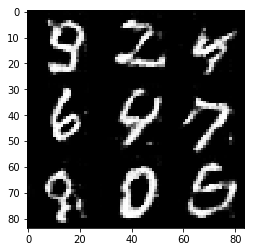

Epoch 2/2... Discriminator Loss: 0.7908... Generator Loss: 1.0545
Epoch 2/2... Discriminator Loss: 1.2007... Generator Loss: 0.6140
Epoch 2/2... Discriminator Loss: 1.8389... Generator Loss: 0.2355
Epoch 2/2... Discriminator Loss: 1.5088... Generator Loss: 0.7425
Epoch 2/2... Discriminator Loss: 1.5023... Generator Loss: 0.3424
Epoch 2/2... Discriminator Loss: 1.1666... Generator Loss: 0.8281
Epoch 2/2... Discriminator Loss: 1.3154... Generator Loss: 0.4984
Epoch 2/2... Discriminator Loss: 1.4139... Generator Loss: 0.6615
Epoch 2/2... Discriminator Loss: 1.5899... Generator Loss: 0.3769
Epoch 2/2... Discriminator Loss: 1.1103... Generator Loss: 0.5820


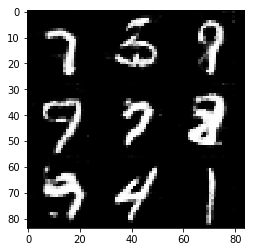

Epoch 2/2... Discriminator Loss: 0.9123... Generator Loss: 1.1627
Epoch 2/2... Discriminator Loss: 1.3206... Generator Loss: 0.7659
Epoch 2/2... Discriminator Loss: 1.4720... Generator Loss: 0.3536
Epoch 2/2... Discriminator Loss: 1.1318... Generator Loss: 0.6630
Epoch 2/2... Discriminator Loss: 1.1394... Generator Loss: 0.6312
Epoch 2/2... Discriminator Loss: 1.1897... Generator Loss: 0.4553
Epoch 2/2... Discriminator Loss: 1.1346... Generator Loss: 0.9989
Epoch 2/2... Discriminator Loss: 1.7501... Generator Loss: 0.2315
Epoch 2/2... Discriminator Loss: 1.4200... Generator Loss: 0.4081
Epoch 2/2... Discriminator Loss: 1.2998... Generator Loss: 0.5004


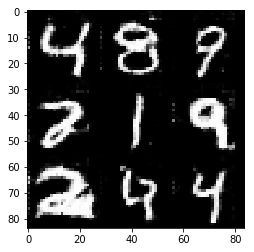

Epoch 2/2... Discriminator Loss: 1.1714... Generator Loss: 0.6958
Epoch 2/2... Discriminator Loss: 1.0695... Generator Loss: 0.7762
Epoch 2/2... Discriminator Loss: 1.6197... Generator Loss: 0.3368
Epoch 2/2... Discriminator Loss: 1.5181... Generator Loss: 0.4094
Epoch 2/2... Discriminator Loss: 1.2228... Generator Loss: 0.7018
Epoch 2/2... Discriminator Loss: 1.1035... Generator Loss: 1.0478
Epoch 2/2... Discriminator Loss: 1.1695... Generator Loss: 0.6489
Epoch 2/2... Discriminator Loss: 1.1809... Generator Loss: 0.7027
Epoch 2/2... Discriminator Loss: 1.2773... Generator Loss: 0.7408
Epoch 2/2... Discriminator Loss: 1.3145... Generator Loss: 0.6829


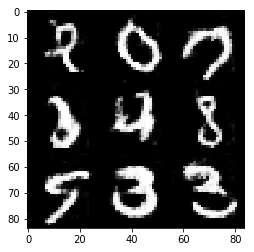

Epoch 2/2... Discriminator Loss: 1.5736... Generator Loss: 0.3653
Epoch 2/2... Discriminator Loss: 1.4233... Generator Loss: 0.4356
Epoch 2/2... Discriminator Loss: 1.3399... Generator Loss: 0.4400
Epoch 2/2... Discriminator Loss: 1.6389... Generator Loss: 0.3255
Epoch 2/2... Discriminator Loss: 1.2568... Generator Loss: 0.5223
Epoch 2/2... Discriminator Loss: 1.1601... Generator Loss: 0.5955
Epoch 2/2... Discriminator Loss: 1.0829... Generator Loss: 0.6506
Epoch 2/2... Discriminator Loss: 1.2390... Generator Loss: 0.5158
Epoch 2/2... Discriminator Loss: 1.0217... Generator Loss: 1.0149
Epoch 2/2... Discriminator Loss: 1.3082... Generator Loss: 0.5875


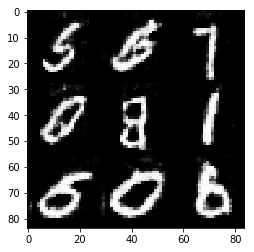

Epoch 2/2... Discriminator Loss: 1.4549... Generator Loss: 0.3758
Epoch 2/2... Discriminator Loss: 1.6411... Generator Loss: 0.2945
Epoch 2/2... Discriminator Loss: 0.9231... Generator Loss: 1.0517
Epoch 2/2... Discriminator Loss: 1.1818... Generator Loss: 0.6248
Epoch 2/2... Discriminator Loss: 1.3181... Generator Loss: 0.4329
Epoch 2/2... Discriminator Loss: 1.4419... Generator Loss: 0.4517
Epoch 2/2... Discriminator Loss: 1.2389... Generator Loss: 0.6124
Epoch 2/2... Discriminator Loss: 1.2783... Generator Loss: 0.5164
Epoch 2/2... Discriminator Loss: 1.5777... Generator Loss: 0.3513
Epoch 2/2... Discriminator Loss: 1.2563... Generator Loss: 0.4778


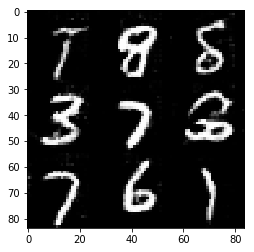

Epoch 2/2... Discriminator Loss: 1.2395... Generator Loss: 0.5364
Epoch 2/2... Discriminator Loss: 1.1495... Generator Loss: 1.1927
Epoch 2/2... Discriminator Loss: 1.1903... Generator Loss: 0.5155
Epoch 2/2... Discriminator Loss: 1.1982... Generator Loss: 0.6479
Epoch 2/2... Discriminator Loss: 1.6583... Generator Loss: 0.3232
Epoch 2/2... Discriminator Loss: 1.2316... Generator Loss: 0.5905
Epoch 2/2... Discriminator Loss: 1.0475... Generator Loss: 0.8310
Epoch 2/2... Discriminator Loss: 1.6363... Generator Loss: 0.3090
Epoch 2/2... Discriminator Loss: 1.6217... Generator Loss: 0.3171
Epoch 2/2... Discriminator Loss: 1.3872... Generator Loss: 0.3877


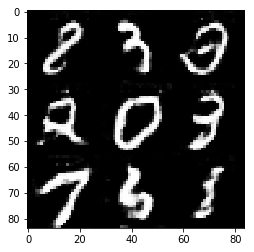

Epoch 2/2... Discriminator Loss: 1.5140... Generator Loss: 0.3811
Epoch 2/2... Discriminator Loss: 2.2070... Generator Loss: 0.1782
Epoch 2/2... Discriminator Loss: 1.4799... Generator Loss: 0.3879
Epoch 2/2... Discriminator Loss: 1.5020... Generator Loss: 0.3864
Epoch 2/2... Discriminator Loss: 1.1711... Generator Loss: 0.7122
Epoch 2/2... Discriminator Loss: 1.4203... Generator Loss: 0.4307
Epoch 2/2... Discriminator Loss: 1.3262... Generator Loss: 0.4684


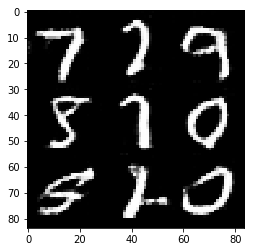

In [12]:
batch_size = 64
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 4.1943... Generator Loss: 0.0322
Epoch 1/1... Discriminator Loss: 1.9239... Generator Loss: 0.4863
Epoch 1/1... Discriminator Loss: 2.1016... Generator Loss: 0.3421
Epoch 1/1... Discriminator Loss: 2.7007... Generator Loss: 0.1047
Epoch 1/1... Discriminator Loss: 1.8500... Generator Loss: 0.3029
Epoch 1/1... Discriminator Loss: 1.3701... Generator Loss: 1.2528
Epoch 1/1... Discriminator Loss: 1.6538... Generator Loss: 0.7270
Epoch 1/1... Discriminator Loss: 1.5535... Generator Loss: 0.5051
Epoch 1/1... Discriminator Loss: 1.3448... Generator Loss: 1.2439
Epoch 1/1... Discriminator Loss: 1.1229... Generator Loss: 0.6793


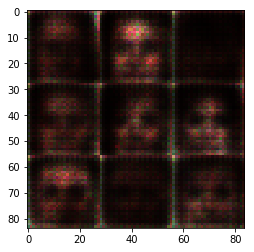

Epoch 1/1... Discriminator Loss: 1.5718... Generator Loss: 0.4294
Epoch 1/1... Discriminator Loss: 1.1823... Generator Loss: 2.2349
Epoch 1/1... Discriminator Loss: 1.6447... Generator Loss: 0.3456
Epoch 1/1... Discriminator Loss: 1.8814... Generator Loss: 0.2992
Epoch 1/1... Discriminator Loss: 1.5953... Generator Loss: 0.3278
Epoch 1/1... Discriminator Loss: 1.6958... Generator Loss: 0.4561
Epoch 1/1... Discriminator Loss: 2.1264... Generator Loss: 0.3203
Epoch 1/1... Discriminator Loss: 1.6594... Generator Loss: 0.5748
Epoch 1/1... Discriminator Loss: 1.8593... Generator Loss: 0.5415
Epoch 1/1... Discriminator Loss: 1.7252... Generator Loss: 0.4453


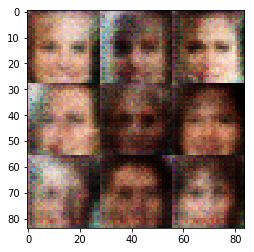

Epoch 1/1... Discriminator Loss: 1.8449... Generator Loss: 0.5505
Epoch 1/1... Discriminator Loss: 1.7296... Generator Loss: 0.5025
Epoch 1/1... Discriminator Loss: 1.7287... Generator Loss: 0.4936
Epoch 1/1... Discriminator Loss: 1.6278... Generator Loss: 0.4951
Epoch 1/1... Discriminator Loss: 1.6849... Generator Loss: 0.5357
Epoch 1/1... Discriminator Loss: 1.6258... Generator Loss: 0.5294
Epoch 1/1... Discriminator Loss: 1.6035... Generator Loss: 0.5156
Epoch 1/1... Discriminator Loss: 1.7246... Generator Loss: 0.4529
Epoch 1/1... Discriminator Loss: 1.6571... Generator Loss: 0.5571
Epoch 1/1... Discriminator Loss: 1.6233... Generator Loss: 0.5455


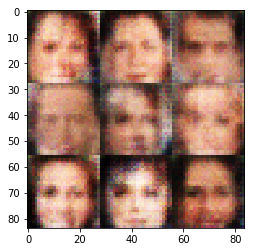

Epoch 1/1... Discriminator Loss: 1.5310... Generator Loss: 0.5537
Epoch 1/1... Discriminator Loss: 1.6242... Generator Loss: 0.5348
Epoch 1/1... Discriminator Loss: 1.7032... Generator Loss: 0.5628
Epoch 1/1... Discriminator Loss: 1.6097... Generator Loss: 0.5738
Epoch 1/1... Discriminator Loss: 1.5516... Generator Loss: 0.5773
Epoch 1/1... Discriminator Loss: 1.4973... Generator Loss: 0.5369
Epoch 1/1... Discriminator Loss: 1.4968... Generator Loss: 0.5796
Epoch 1/1... Discriminator Loss: 1.4397... Generator Loss: 0.6589
Epoch 1/1... Discriminator Loss: 1.5425... Generator Loss: 0.5950
Epoch 1/1... Discriminator Loss: 1.4896... Generator Loss: 0.6378


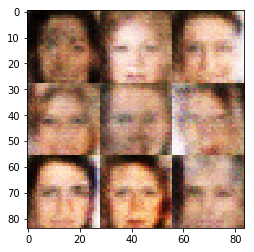

Epoch 1/1... Discriminator Loss: 1.5826... Generator Loss: 0.5373
Epoch 1/1... Discriminator Loss: 1.5704... Generator Loss: 0.5590
Epoch 1/1... Discriminator Loss: 1.5992... Generator Loss: 0.5532
Epoch 1/1... Discriminator Loss: 1.6197... Generator Loss: 0.5914
Epoch 1/1... Discriminator Loss: 1.6167... Generator Loss: 0.5900
Epoch 1/1... Discriminator Loss: 1.4292... Generator Loss: 0.6312
Epoch 1/1... Discriminator Loss: 1.5805... Generator Loss: 0.5796
Epoch 1/1... Discriminator Loss: 1.5201... Generator Loss: 0.5795
Epoch 1/1... Discriminator Loss: 1.4359... Generator Loss: 0.6026
Epoch 1/1... Discriminator Loss: 1.5359... Generator Loss: 0.6061


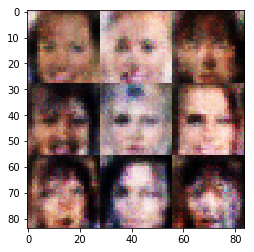

Epoch 1/1... Discriminator Loss: 1.4575... Generator Loss: 0.6008
Epoch 1/1... Discriminator Loss: 1.5185... Generator Loss: 0.5879
Epoch 1/1... Discriminator Loss: 1.5227... Generator Loss: 0.5782
Epoch 1/1... Discriminator Loss: 1.5744... Generator Loss: 0.5684
Epoch 1/1... Discriminator Loss: 1.5314... Generator Loss: 0.6371
Epoch 1/1... Discriminator Loss: 1.4872... Generator Loss: 0.5795
Epoch 1/1... Discriminator Loss: 1.4887... Generator Loss: 0.6204
Epoch 1/1... Discriminator Loss: 1.5763... Generator Loss: 0.6172
Epoch 1/1... Discriminator Loss: 1.4960... Generator Loss: 0.5810
Epoch 1/1... Discriminator Loss: 1.4770... Generator Loss: 0.6048


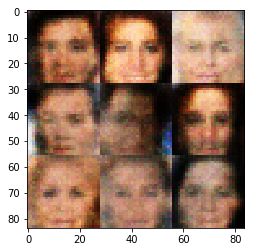

Epoch 1/1... Discriminator Loss: 1.4744... Generator Loss: 0.6022
Epoch 1/1... Discriminator Loss: 1.4564... Generator Loss: 0.6384
Epoch 1/1... Discriminator Loss: 1.4769... Generator Loss: 0.6455
Epoch 1/1... Discriminator Loss: 1.5120... Generator Loss: 0.5958
Epoch 1/1... Discriminator Loss: 1.4510... Generator Loss: 0.6139
Epoch 1/1... Discriminator Loss: 1.4486... Generator Loss: 0.5904
Epoch 1/1... Discriminator Loss: 1.5783... Generator Loss: 0.5306
Epoch 1/1... Discriminator Loss: 1.5395... Generator Loss: 0.5555
Epoch 1/1... Discriminator Loss: 1.5746... Generator Loss: 0.5467
Epoch 1/1... Discriminator Loss: 1.5110... Generator Loss: 0.5736


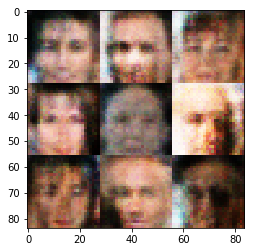

Epoch 1/1... Discriminator Loss: 1.5070... Generator Loss: 0.6149
Epoch 1/1... Discriminator Loss: 1.6120... Generator Loss: 0.5631
Epoch 1/1... Discriminator Loss: 1.4887... Generator Loss: 0.6180
Epoch 1/1... Discriminator Loss: 1.4755... Generator Loss: 0.5829
Epoch 1/1... Discriminator Loss: 1.4670... Generator Loss: 0.6259
Epoch 1/1... Discriminator Loss: 1.5277... Generator Loss: 0.6063
Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 0.6990
Epoch 1/1... Discriminator Loss: 1.4397... Generator Loss: 0.6535
Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.5928
Epoch 1/1... Discriminator Loss: 1.4505... Generator Loss: 0.6392


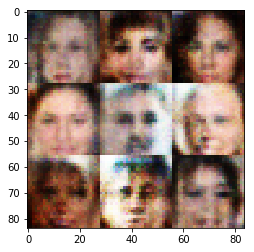

Epoch 1/1... Discriminator Loss: 1.4877... Generator Loss: 0.6152
Epoch 1/1... Discriminator Loss: 1.4866... Generator Loss: 0.5947
Epoch 1/1... Discriminator Loss: 1.4949... Generator Loss: 0.6102
Epoch 1/1... Discriminator Loss: 1.4176... Generator Loss: 0.6321
Epoch 1/1... Discriminator Loss: 1.4640... Generator Loss: 0.5695
Epoch 1/1... Discriminator Loss: 1.4982... Generator Loss: 0.6081
Epoch 1/1... Discriminator Loss: 1.4591... Generator Loss: 0.6444
Epoch 1/1... Discriminator Loss: 1.5311... Generator Loss: 0.5617
Epoch 1/1... Discriminator Loss: 1.4094... Generator Loss: 0.6551
Epoch 1/1... Discriminator Loss: 1.4573... Generator Loss: 0.6634


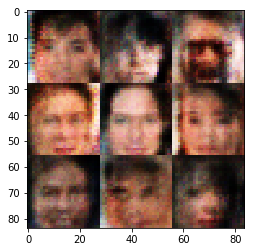

Epoch 1/1... Discriminator Loss: 1.4797... Generator Loss: 0.5845
Epoch 1/1... Discriminator Loss: 1.4882... Generator Loss: 0.6252
Epoch 1/1... Discriminator Loss: 1.4971... Generator Loss: 0.6113
Epoch 1/1... Discriminator Loss: 1.4507... Generator Loss: 0.6501
Epoch 1/1... Discriminator Loss: 1.5022... Generator Loss: 0.6518
Epoch 1/1... Discriminator Loss: 1.4496... Generator Loss: 0.6380
Epoch 1/1... Discriminator Loss: 1.4886... Generator Loss: 0.6339
Epoch 1/1... Discriminator Loss: 1.4921... Generator Loss: 0.6519
Epoch 1/1... Discriminator Loss: 1.4208... Generator Loss: 0.6877
Epoch 1/1... Discriminator Loss: 1.5317... Generator Loss: 0.6262


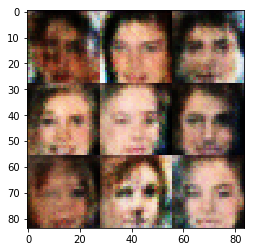

Epoch 1/1... Discriminator Loss: 1.4762... Generator Loss: 0.6656
Epoch 1/1... Discriminator Loss: 1.4638... Generator Loss: 0.6495
Epoch 1/1... Discriminator Loss: 1.4518... Generator Loss: 0.6208
Epoch 1/1... Discriminator Loss: 1.4995... Generator Loss: 0.6174
Epoch 1/1... Discriminator Loss: 1.4910... Generator Loss: 0.5968
Epoch 1/1... Discriminator Loss: 1.4990... Generator Loss: 0.6166
Epoch 1/1... Discriminator Loss: 1.4719... Generator Loss: 0.6290
Epoch 1/1... Discriminator Loss: 1.5416... Generator Loss: 0.5872
Epoch 1/1... Discriminator Loss: 1.4335... Generator Loss: 0.6009
Epoch 1/1... Discriminator Loss: 1.5367... Generator Loss: 0.5949


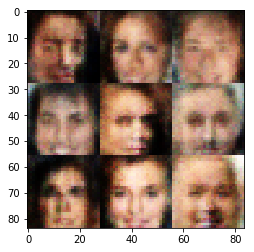

Epoch 1/1... Discriminator Loss: 1.4753... Generator Loss: 0.6285
Epoch 1/1... Discriminator Loss: 1.4633... Generator Loss: 0.6638
Epoch 1/1... Discriminator Loss: 1.4581... Generator Loss: 0.5828
Epoch 1/1... Discriminator Loss: 1.4473... Generator Loss: 0.6510
Epoch 1/1... Discriminator Loss: 1.4492... Generator Loss: 0.5835
Epoch 1/1... Discriminator Loss: 1.4613... Generator Loss: 0.6010
Epoch 1/1... Discriminator Loss: 1.5073... Generator Loss: 0.6604
Epoch 1/1... Discriminator Loss: 1.4624... Generator Loss: 0.6278
Epoch 1/1... Discriminator Loss: 1.5158... Generator Loss: 0.6204
Epoch 1/1... Discriminator Loss: 1.4917... Generator Loss: 0.6290


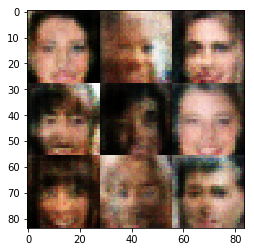

Epoch 1/1... Discriminator Loss: 1.5381... Generator Loss: 0.6258
Epoch 1/1... Discriminator Loss: 1.4668... Generator Loss: 0.6278
Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.6362
Epoch 1/1... Discriminator Loss: 1.4736... Generator Loss: 0.6171
Epoch 1/1... Discriminator Loss: 1.4329... Generator Loss: 0.6454
Epoch 1/1... Discriminator Loss: 1.4888... Generator Loss: 0.5983
Epoch 1/1... Discriminator Loss: 1.4431... Generator Loss: 0.6398
Epoch 1/1... Discriminator Loss: 1.4708... Generator Loss: 0.5689
Epoch 1/1... Discriminator Loss: 1.4177... Generator Loss: 0.5776
Epoch 1/1... Discriminator Loss: 1.4935... Generator Loss: 0.6034


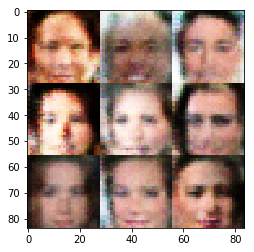

Epoch 1/1... Discriminator Loss: 1.3740... Generator Loss: 0.6440
Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 0.7024
Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.6795
Epoch 1/1... Discriminator Loss: 1.3546... Generator Loss: 0.6182
Epoch 1/1... Discriminator Loss: 1.5452... Generator Loss: 0.5067
Epoch 1/1... Discriminator Loss: 1.4748... Generator Loss: 0.4840
Epoch 1/1... Discriminator Loss: 1.3265... Generator Loss: 0.7071
Epoch 1/1... Discriminator Loss: 1.4123... Generator Loss: 0.6891
Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.4894
Epoch 1/1... Discriminator Loss: 1.3253... Generator Loss: 0.7192


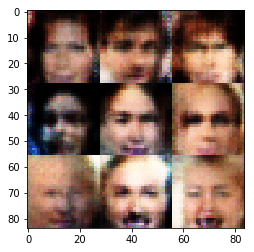

Epoch 1/1... Discriminator Loss: 1.4827... Generator Loss: 0.4950
Epoch 1/1... Discriminator Loss: 1.4555... Generator Loss: 0.6235
Epoch 1/1... Discriminator Loss: 1.5615... Generator Loss: 0.4444
Epoch 1/1... Discriminator Loss: 1.4324... Generator Loss: 0.5999
Epoch 1/1... Discriminator Loss: 1.6063... Generator Loss: 0.4595
Epoch 1/1... Discriminator Loss: 1.5173... Generator Loss: 0.6458
Epoch 1/1... Discriminator Loss: 1.2843... Generator Loss: 0.7570
Epoch 1/1... Discriminator Loss: 1.4599... Generator Loss: 0.6318
Epoch 1/1... Discriminator Loss: 1.5589... Generator Loss: 0.4836
Epoch 1/1... Discriminator Loss: 1.4575... Generator Loss: 0.5687


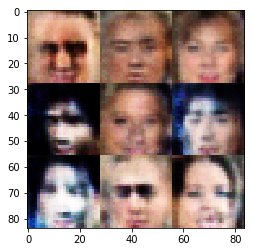

Epoch 1/1... Discriminator Loss: 1.3065... Generator Loss: 0.9337
Epoch 1/1... Discriminator Loss: 1.5517... Generator Loss: 0.6230
Epoch 1/1... Discriminator Loss: 1.3297... Generator Loss: 0.8192
Epoch 1/1... Discriminator Loss: 1.4871... Generator Loss: 0.4734
Epoch 1/1... Discriminator Loss: 1.4892... Generator Loss: 0.7295
Epoch 1/1... Discriminator Loss: 1.5798... Generator Loss: 0.4789
Epoch 1/1... Discriminator Loss: 1.5036... Generator Loss: 0.5746
Epoch 1/1... Discriminator Loss: 1.3368... Generator Loss: 0.8591
Epoch 1/1... Discriminator Loss: 1.5163... Generator Loss: 0.5048
Epoch 1/1... Discriminator Loss: 1.4645... Generator Loss: 0.5977


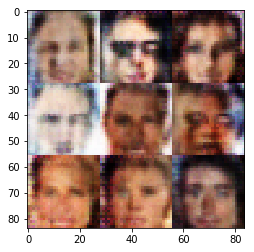

Epoch 1/1... Discriminator Loss: 1.4345... Generator Loss: 0.6920
Epoch 1/1... Discriminator Loss: 1.5483... Generator Loss: 0.5789
Epoch 1/1... Discriminator Loss: 1.4666... Generator Loss: 0.5616
Epoch 1/1... Discriminator Loss: 1.5568... Generator Loss: 0.6037
Epoch 1/1... Discriminator Loss: 1.4727... Generator Loss: 0.6105
Epoch 1/1... Discriminator Loss: 1.5568... Generator Loss: 0.4913
Epoch 1/1... Discriminator Loss: 1.4781... Generator Loss: 0.5494
Epoch 1/1... Discriminator Loss: 1.4615... Generator Loss: 0.6297
Epoch 1/1... Discriminator Loss: 1.4404... Generator Loss: 0.6720
Epoch 1/1... Discriminator Loss: 1.5206... Generator Loss: 0.5831


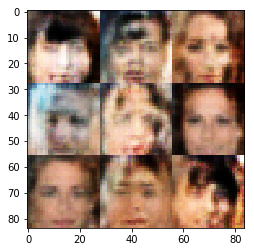

Epoch 1/1... Discriminator Loss: 1.5102... Generator Loss: 0.6007
Epoch 1/1... Discriminator Loss: 1.4828... Generator Loss: 0.5588
Epoch 1/1... Discriminator Loss: 1.4702... Generator Loss: 0.5897
Epoch 1/1... Discriminator Loss: 1.4870... Generator Loss: 0.6223
Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 0.6551
Epoch 1/1... Discriminator Loss: 1.5026... Generator Loss: 0.5620
Epoch 1/1... Discriminator Loss: 1.5150... Generator Loss: 0.6041
Epoch 1/1... Discriminator Loss: 1.4798... Generator Loss: 0.5518
Epoch 1/1... Discriminator Loss: 1.4958... Generator Loss: 0.6073
Epoch 1/1... Discriminator Loss: 1.4609... Generator Loss: 0.5795


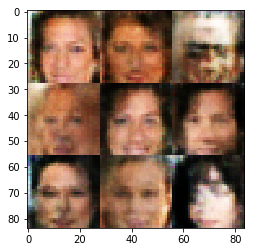

Epoch 1/1... Discriminator Loss: 1.5390... Generator Loss: 0.5555
Epoch 1/1... Discriminator Loss: 1.4790... Generator Loss: 0.6527
Epoch 1/1... Discriminator Loss: 1.4831... Generator Loss: 0.6177
Epoch 1/1... Discriminator Loss: 1.4961... Generator Loss: 0.6086
Epoch 1/1... Discriminator Loss: 1.4595... Generator Loss: 0.5792
Epoch 1/1... Discriminator Loss: 1.4981... Generator Loss: 0.6120
Epoch 1/1... Discriminator Loss: 1.4356... Generator Loss: 0.6330
Epoch 1/1... Discriminator Loss: 1.5199... Generator Loss: 0.5944
Epoch 1/1... Discriminator Loss: 1.5115... Generator Loss: 0.5488
Epoch 1/1... Discriminator Loss: 1.4698... Generator Loss: 0.5948


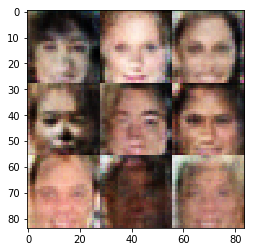

Epoch 1/1... Discriminator Loss: 1.5034... Generator Loss: 0.5977
Epoch 1/1... Discriminator Loss: 1.4683... Generator Loss: 0.6061
Epoch 1/1... Discriminator Loss: 1.4872... Generator Loss: 0.5967
Epoch 1/1... Discriminator Loss: 1.4642... Generator Loss: 0.5820
Epoch 1/1... Discriminator Loss: 1.4938... Generator Loss: 0.5652
Epoch 1/1... Discriminator Loss: 1.5042... Generator Loss: 0.6087
Epoch 1/1... Discriminator Loss: 1.5170... Generator Loss: 0.6093
Epoch 1/1... Discriminator Loss: 1.5036... Generator Loss: 0.5777
Epoch 1/1... Discriminator Loss: 1.4798... Generator Loss: 0.6206
Epoch 1/1... Discriminator Loss: 1.5156... Generator Loss: 0.6164


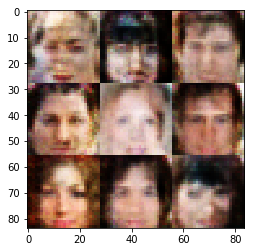

Epoch 1/1... Discriminator Loss: 1.4601... Generator Loss: 0.6257
Epoch 1/1... Discriminator Loss: 1.4689... Generator Loss: 0.6398
Epoch 1/1... Discriminator Loss: 1.4743... Generator Loss: 0.6419
Epoch 1/1... Discriminator Loss: 1.4760... Generator Loss: 0.6023
Epoch 1/1... Discriminator Loss: 1.4450... Generator Loss: 0.6521
Epoch 1/1... Discriminator Loss: 1.4698... Generator Loss: 0.6540
Epoch 1/1... Discriminator Loss: 1.5868... Generator Loss: 0.5514
Epoch 1/1... Discriminator Loss: 1.4262... Generator Loss: 0.6113
Epoch 1/1... Discriminator Loss: 1.4848... Generator Loss: 0.5633
Epoch 1/1... Discriminator Loss: 1.4763... Generator Loss: 0.6051


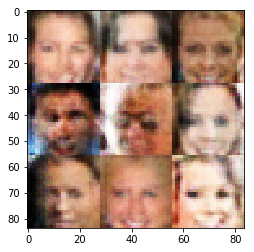

Epoch 1/1... Discriminator Loss: 1.4771... Generator Loss: 0.5667
Epoch 1/1... Discriminator Loss: 1.4753... Generator Loss: 0.5935
Epoch 1/1... Discriminator Loss: 1.4900... Generator Loss: 0.5646
Epoch 1/1... Discriminator Loss: 1.4922... Generator Loss: 0.6110
Epoch 1/1... Discriminator Loss: 1.3911... Generator Loss: 0.6510
Epoch 1/1... Discriminator Loss: 1.5204... Generator Loss: 0.5961
Epoch 1/1... Discriminator Loss: 1.4904... Generator Loss: 0.5764
Epoch 1/1... Discriminator Loss: 1.4713... Generator Loss: 0.5427
Epoch 1/1... Discriminator Loss: 1.4936... Generator Loss: 0.5890
Epoch 1/1... Discriminator Loss: 1.5126... Generator Loss: 0.5973


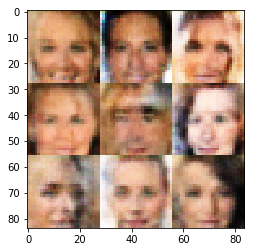

Epoch 1/1... Discriminator Loss: 1.4868... Generator Loss: 0.5819
Epoch 1/1... Discriminator Loss: 1.4985... Generator Loss: 0.5761
Epoch 1/1... Discriminator Loss: 1.4476... Generator Loss: 0.6486
Epoch 1/1... Discriminator Loss: 1.4463... Generator Loss: 0.6818
Epoch 1/1... Discriminator Loss: 1.5358... Generator Loss: 0.5705
Epoch 1/1... Discriminator Loss: 1.4526... Generator Loss: 0.6416
Epoch 1/1... Discriminator Loss: 1.5032... Generator Loss: 0.6149
Epoch 1/1... Discriminator Loss: 1.5084... Generator Loss: 0.5918
Epoch 1/1... Discriminator Loss: 1.5068... Generator Loss: 0.5707
Epoch 1/1... Discriminator Loss: 1.4273... Generator Loss: 0.6638


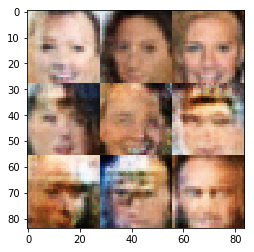

Epoch 1/1... Discriminator Loss: 1.4968... Generator Loss: 0.5559
Epoch 1/1... Discriminator Loss: 1.4483... Generator Loss: 0.6584
Epoch 1/1... Discriminator Loss: 1.5280... Generator Loss: 0.5582
Epoch 1/1... Discriminator Loss: 1.4651... Generator Loss: 0.5951
Epoch 1/1... Discriminator Loss: 1.5230... Generator Loss: 0.5830
Epoch 1/1... Discriminator Loss: 1.5270... Generator Loss: 0.5723
Epoch 1/1... Discriminator Loss: 1.5390... Generator Loss: 0.5465
Epoch 1/1... Discriminator Loss: 1.4402... Generator Loss: 0.5856
Epoch 1/1... Discriminator Loss: 1.4799... Generator Loss: 0.5870
Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 0.7498


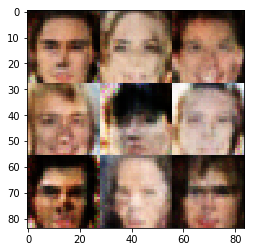

Epoch 1/1... Discriminator Loss: 1.4375... Generator Loss: 0.5997
Epoch 1/1... Discriminator Loss: 1.4791... Generator Loss: 0.5875
Epoch 1/1... Discriminator Loss: 1.5649... Generator Loss: 0.6239
Epoch 1/1... Discriminator Loss: 1.5496... Generator Loss: 0.5248
Epoch 1/1... Discriminator Loss: 1.4989... Generator Loss: 0.6005
Epoch 1/1... Discriminator Loss: 1.4192... Generator Loss: 0.7143
Epoch 1/1... Discriminator Loss: 1.5427... Generator Loss: 0.6028
Epoch 1/1... Discriminator Loss: 1.5055... Generator Loss: 0.5676
Epoch 1/1... Discriminator Loss: 1.4057... Generator Loss: 0.6527
Epoch 1/1... Discriminator Loss: 1.3745... Generator Loss: 0.7239


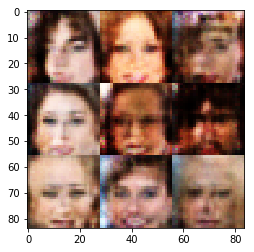

Epoch 1/1... Discriminator Loss: 1.6174... Generator Loss: 0.5390
Epoch 1/1... Discriminator Loss: 1.4933... Generator Loss: 0.5470
Epoch 1/1... Discriminator Loss: 1.5685... Generator Loss: 0.5344
Epoch 1/1... Discriminator Loss: 1.4831... Generator Loss: 0.6169
Epoch 1/1... Discriminator Loss: 1.4989... Generator Loss: 0.5021
Epoch 1/1... Discriminator Loss: 1.5242... Generator Loss: 0.6157
Epoch 1/1... Discriminator Loss: 1.5087... Generator Loss: 0.6228
Epoch 1/1... Discriminator Loss: 1.5564... Generator Loss: 0.5340
Epoch 1/1... Discriminator Loss: 1.4751... Generator Loss: 0.6039
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.6976


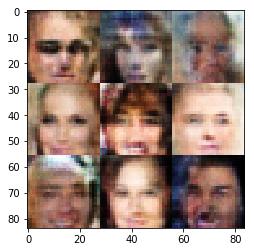

Epoch 1/1... Discriminator Loss: 1.4739... Generator Loss: 0.6533
Epoch 1/1... Discriminator Loss: 1.5063... Generator Loss: 0.6042
Epoch 1/1... Discriminator Loss: 1.5250... Generator Loss: 0.5411
Epoch 1/1... Discriminator Loss: 1.5270... Generator Loss: 0.5731
Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 0.7104
Epoch 1/1... Discriminator Loss: 1.3951... Generator Loss: 0.6107
Epoch 1/1... Discriminator Loss: 1.5135... Generator Loss: 0.5804
Epoch 1/1... Discriminator Loss: 1.5036... Generator Loss: 0.5378
Epoch 1/1... Discriminator Loss: 1.5088... Generator Loss: 0.6544
Epoch 1/1... Discriminator Loss: 1.4683... Generator Loss: 0.5788


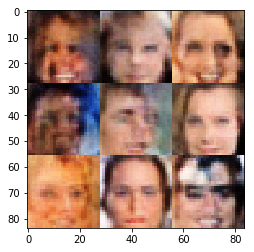

Epoch 1/1... Discriminator Loss: 1.4632... Generator Loss: 0.6730
Epoch 1/1... Discriminator Loss: 1.4745... Generator Loss: 0.5691
Epoch 1/1... Discriminator Loss: 1.4085... Generator Loss: 0.7142
Epoch 1/1... Discriminator Loss: 1.4669... Generator Loss: 0.5638
Epoch 1/1... Discriminator Loss: 1.4935... Generator Loss: 0.5554
Epoch 1/1... Discriminator Loss: 1.4968... Generator Loss: 0.5260
Epoch 1/1... Discriminator Loss: 1.5190... Generator Loss: 0.5894
Epoch 1/1... Discriminator Loss: 1.5206... Generator Loss: 0.5065
Epoch 1/1... Discriminator Loss: 1.5634... Generator Loss: 0.4996
Epoch 1/1... Discriminator Loss: 1.5314... Generator Loss: 0.5364


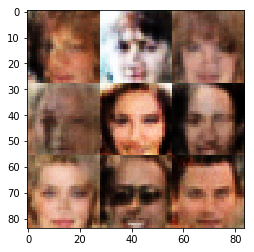

Epoch 1/1... Discriminator Loss: 1.4586... Generator Loss: 0.4933
Epoch 1/1... Discriminator Loss: 1.5118... Generator Loss: 0.5321
Epoch 1/1... Discriminator Loss: 1.4955... Generator Loss: 0.5520
Epoch 1/1... Discriminator Loss: 1.5057... Generator Loss: 0.5549
Epoch 1/1... Discriminator Loss: 1.5007... Generator Loss: 0.5523
Epoch 1/1... Discriminator Loss: 1.4994... Generator Loss: 0.4965
Epoch 1/1... Discriminator Loss: 1.4366... Generator Loss: 0.7433
Epoch 1/1... Discriminator Loss: 1.5528... Generator Loss: 0.6003
Epoch 1/1... Discriminator Loss: 1.4869... Generator Loss: 0.5327
Epoch 1/1... Discriminator Loss: 1.5413... Generator Loss: 0.5302


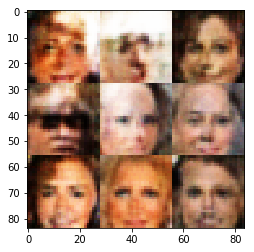

Epoch 1/1... Discriminator Loss: 1.5123... Generator Loss: 0.5206
Epoch 1/1... Discriminator Loss: 1.4966... Generator Loss: 0.5241
Epoch 1/1... Discriminator Loss: 1.5336... Generator Loss: 0.5749
Epoch 1/1... Discriminator Loss: 1.4707... Generator Loss: 0.5682
Epoch 1/1... Discriminator Loss: 1.5199... Generator Loss: 0.6056
Epoch 1/1... Discriminator Loss: 1.5023... Generator Loss: 0.4676
Epoch 1/1... Discriminator Loss: 1.4558... Generator Loss: 0.5826
Epoch 1/1... Discriminator Loss: 1.5815... Generator Loss: 0.5825
Epoch 1/1... Discriminator Loss: 1.5399... Generator Loss: 0.5721
Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 0.6742


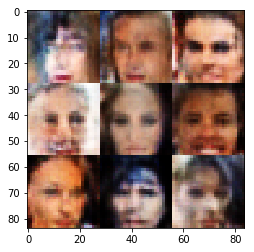

Epoch 1/1... Discriminator Loss: 1.5365... Generator Loss: 0.5506
Epoch 1/1... Discriminator Loss: 1.4540... Generator Loss: 0.5771
Epoch 1/1... Discriminator Loss: 1.5459... Generator Loss: 0.5143
Epoch 1/1... Discriminator Loss: 1.4778... Generator Loss: 0.6568
Epoch 1/1... Discriminator Loss: 1.5320... Generator Loss: 0.6100
Epoch 1/1... Discriminator Loss: 1.5428... Generator Loss: 0.5522
Epoch 1/1... Discriminator Loss: 1.5419... Generator Loss: 0.5430
Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 0.6258
Epoch 1/1... Discriminator Loss: 1.5117... Generator Loss: 0.6207
Epoch 1/1... Discriminator Loss: 1.5714... Generator Loss: 0.5473


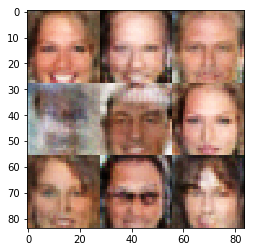

Epoch 1/1... Discriminator Loss: 1.5943... Generator Loss: 0.5616
Epoch 1/1... Discriminator Loss: 1.4285... Generator Loss: 0.5914
Epoch 1/1... Discriminator Loss: 1.5111... Generator Loss: 0.5853
Epoch 1/1... Discriminator Loss: 1.4738... Generator Loss: 0.5560
Epoch 1/1... Discriminator Loss: 1.5011... Generator Loss: 0.6138
Epoch 1/1... Discriminator Loss: 1.4935... Generator Loss: 0.5115


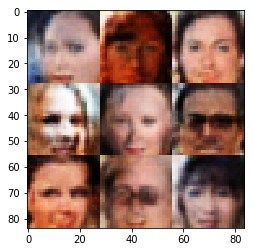

In [13]:
batch_size = 64
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.